In [7]:
# Load & query database
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [9]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

## 1. Querying Data & Exploratory Data Analysis

In [10]:
query = """SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"""

In [11]:
query = """SELECT * FROM 'OrderDetail';"""

In [12]:
cur.execute(query)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [13]:
df.groupby('Discount').Quantity.describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


Since there are very few examples for discounts of 1%-6% (excluding 5%) it makes sense to drop these. Additionally these are odd reduction amounts that are not commonly occuring. Usually, people think in terms of 5 % increments.

In [14]:
df = df[~df.Discount.isin([0.01, 0.02, 0.03, 0.04, 0.06])]

In [15]:
discount_df = df[df.Discount != 0]
fullprice_df = df[df.Discount == 0]

In [16]:
product_ids = list(discount_df.ProductId.unique())
product_ids.sort()

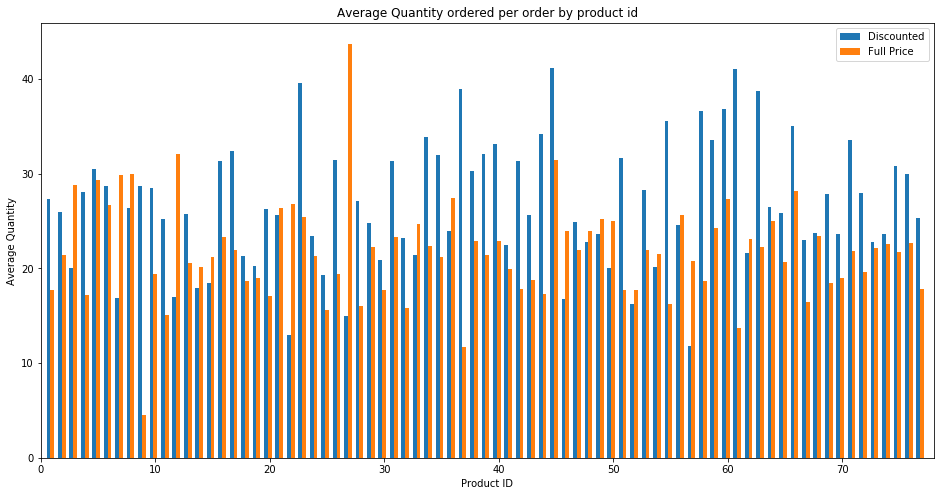

In [17]:
plt.figure(figsize=(16,8))

width = np.min(np.diff(product_ids))/3
plt.bar(product_ids - width, discount_df.groupby('ProductId').Quantity.mean(), width, label='Discounted')
plt.bar(product_ids, fullprice_df.groupby('ProductId').Quantity.mean(), width, label='Full Price')
plt.xlim(0, max(product_ids)+1)
plt.legend()
plt.title("Average Quantity ordered per order by product id")
plt.xlabel('Product ID')
plt.ylabel("Average Quantity")
plt.show();

The graph above shows each product and the average quantity ordered per order, when the item was discounted (in blue) vs. when the item was not discounted (in orange). Very often it seems as if more quantities were ordered when the item was discounted. However, there are some cases where this isn't the case. We need to further investigate to see if we can safely say that discounting a product encourages buying more of the product.

### Mean and SD of discount vs. full price orders

In [18]:
print("Mean quantity in full price orders {} vs. discounted: {}".format(round(fullprice_df.Quantity.mean(), 1)
                                                                         ,round(discount_df.Quantity.mean(),1)))
print("SD full price {} vs. discounted {}".format(round(np.std(fullprice_df.Quantity),1 ),
                                                    round(np.std(discount_df.Quantity),1 ) ))

Mean quantity in full price orders 21.7 vs. discounted: 27.4
SD full price 17.5 vs. discounted 20.7


Taking a look at the mean values and total values, we can see that on average people order more when the item is discounted (by around ~6 more), than when full price. Below, total sum of quantity ordered is more for full price, however this may simply be a relic of there being more orders for full price items. Perhaps, the items were discounted during only a limited period.

In [19]:
fullprice_df.Quantity.sum(), discount_df.Quantity.sum()

(28599, 22704)

In [20]:
import warnings
warnings.filterwarnings("ignore")

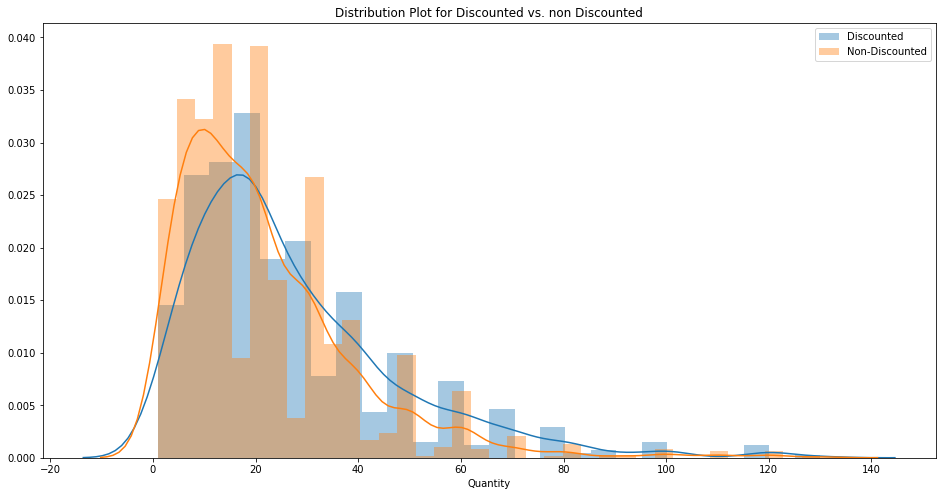

In [21]:
plt.figure(figsize=(16,8))
sns.distplot(discount_df.Quantity, label='Discounted')
sns.distplot(fullprice_df.Quantity, label='Non-Discounted').set_title("Distribution Plot for Discounted vs. non Discounted")
plt.legend()
plt.show();

Plotting the distribution of the two sets of full price vs. discounted, we see there is a tail on orders with large quantities and a skew towards ordering fewer quantities. Below we test for normal distribution to know whether to assume normal distribution of data.

### **Checking for normal distributions**
There is no difference between sample & hypothetical normal distribution.

**Acceptance Criteria**: If the calculated value is less than the critical value, accept the null hypothesis.  
**Rejection Criteria**: If the calculated value is greater than the critical value, reject the null hypothesis.

We can use KS Test to test for normal distribution.

In [22]:
#KS test to see if the data comes from the same distributions
print(stats.kstest(discount_df.Quantity, 'norm', args=(discount_df.Quantity.mean(), discount_df.Quantity.std()))) 
print(stats.kstest(fullprice_df.Quantity, 'norm',
                   args=(fullprice_df.Quantity.mean(), fullprice_df.Quantity.std() )))


KstestResult(statistic=0.1540171703044333, pvalue=0.0)
KstestResult(statistic=0.1571445192364258, pvalue=0.0)


The p-values for both sets of data are 0, which means that we can reject the null hypothesis that the ditribution is normal. This means we should use Welch's T-test which does not assume equal variances.

### Checking difference in distributions between two datasets
There is no difference between the two dataset's distribution

In [23]:
print(stats.ks_2samp(fullprice_df.Quantity,discount_df.Quantity))

Ks_2sampResult(statistic=0.12838964056682312, pvalue=8.520810950306207e-08)


The third test, tests whether the distribution of the sets differ from each other. The p-value is less than 0.05 which means they come from the same distribution.

### Hypothesis 1
**Question**: From the graph above, we suspect that there is a difference in quantity of items ordered when the item is discounted vs. full price. Here we investigate whether this is true  
**H0**: There is no difference in quantity of items ordered when there is a discount vs. full price.  
**H1**: There is an increase in quantity of items ordered when there is a discount.

Here we use Welch's T-test for difference between the groups, since we do not assume normal distribution.

In [24]:
#when equal_var=False, welch's t test is used
t, p = stats.ttest_ind(discount_df.Quantity, fullprice_df.Quantity, equal_var=False) 

In [25]:
if p < 0.025:
    print("Reject null hypothesis. There is an increase in quantity ordered when there is a discount.")
else:
    print("There is an incrase in the quantity ordered when there is a discount.")
print("T-stat: {}, p-value: {}".format(round(t,2), p))

Reject null hypothesis. There is an increase in quantity ordered when there is a discount.
T-stat: 6.51, p-value: 1.0051255540843165e-10


### **Hypothesis 2**
**Question**: Is amount of discount significant in predicting quantity of the item per order?  
**H0**: There is no significant difference in quantity of orders based on the amount of discount.  
**H1**: There is no significant difference in quantity of orders based on the amount of discount.

Here we use ANOVA to whether the different discount groups (different amounts) is significant in quantity ordered

In [26]:
# Your code here
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


Treating each discount group as a categorical variable, and using an anova to test the multiple categories, we get a p-value less than 0.05. This means we can reject the null hypothesis and amount of discount is significant in order quantity 

### **Hypothesis 2(a):**  At what price is discount significant?
To determine at which discount amount is significant in predicting quantity, we can build a baseline linear regression model, with a categorical vairable for discount amount to investgiate the effect of each group.

In [27]:
df_ols = pd.get_dummies(df, columns=['Discount'], prefix=["discount"])
X = df_ols.drop(['Id', 'OrderId', 'ProductId'], axis=1)
new_columns = []
for x in X.columns:
    x = x.replace(".", '')
    new_columns.append(x)
X.columns = new_columns
X.head()

,UnitPrice,Quantity,discount_00,discount_005,discount_01,discount_015,discount_02,discount_025
0,14.0,12,1,0,0,0,0,0
1,9.8,10,1,0,0,0,0,0
2,34.8,5,1,0,0,0,0,0
3,18.6,9,1,0,0,0,0,0
4,42.4,40,1,0,0,0,0,0


In [28]:
outcome = 'Quantity'
predictors = X.drop(columns=['Quantity', 'UnitPrice']).columns
f = '+'.join(predictors)
formula = outcome + '~' + f
stats_model = ols(formula=formula, data=X).fit()

In [29]:
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.799
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.84e-09
Time:                        14:01:17   Log-Likelihood:                -9344.5
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2141   BIC:                         1.873e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.6586      0.473     47.858      0.000      21.730      23.587
discount_00     -0.9434      0.645     -1.462      0.144      -2.209       0.322
discount_005     5.3522      1.261      4.243      0.000       2.878       7.826
discount_01      2.5784      1.299      1.986      0.047       0.032       5.125
discount_015     5.7235      1.355      4.225      0.000       3.067       8.380
discount_02      4.3662      1.340      3.259      0.001       1.739       6.994
discount_025     5.5816      1.366      4.085      0.000       2.902       8.261
==============================================================================
Omnibus:                      784.809   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3071.552
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                       7.670   Cond. No.                     1.55e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Here we can see that all discounts from 5%-25% are significant in predicting quantity ordered. However, the coefficients show that 10% discount has less of an effect.

### **Hypothesis 3**
**Question**: Does unit price & discount have an effect on quantity per order purchased?  
**H0**: Unit price & discount does not have an effect on quantity purchased.  
**H1**: Unit price & discount has an effect on total quantity purchased.

In [30]:
formula = 'Quantity ~ C(Discount) + UnitPrice'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17338.678292     5.0  9.788898  2.905851e-09
UnitPrice        39.528985     1.0  0.111584  7.383802e-01
Residual     758099.036940  2140.0       NaN           NaN


In [31]:
outcome = 'Quantity'
predictors = X.drop(columns=['Quantity']).columns
f = '+'.join(predictors)
formula = outcome + '~' + f
stats_model = ols(formula=formula, data=X).fit()

In [32]:
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.181
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.07e-09
Time:                        14:01:21   Log-Likelihood:                -9344.4
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2140   BIC:                         1.874e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.5566      0.564     40.024      0.000      21.451      23.662
UnitPrice        0.0046      0.014      0.334      0.738      -0.022       0.031
discount_00     -0.9605      0.647     -1.484      0.138      -2.230       0.309
discount_005     5.3140      1.267      4.194      0.000       2.829       7.799
discount_01      2.5658      1.299      1.975      0.048       0.018       5.114
discount_015     5.7210      1.355      4.222      0.000       3.064       8.378
discount_02      4.3611      1.340      3.254      0.001       1.733       6.989
discount_025     5.5552      1.369      4.058      0.000       2.871       8.240
==============================================================================
Omnibus:                      784.957   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3073.377
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                       7.671   Cond. No.                     6.14e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  9e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

UnitPrice does not have an effect on quantity ordered. Both the anova, and the OLS model show that the p-value is not less than 0.05

### **Hypothesis 4**

**Question** is there an interaction between unit price & discount? The idea is that some low cost items (for example, paper clips) a 5 vs. 25 % discount will be just a few pennies or maybe a dollar.  
First, let's look more closely at the unit price feature.

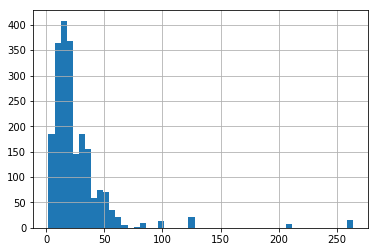

In [33]:
df['UnitPrice'].hist(bins = 50)

Looking at the histogram, we could partition the data into three bins, indicating lower cost, medium, and higher cost items. I chose to categorize into bins of unit prices less than \\$25, \\$25-50, and greater than \\$50

In [34]:
less_25_df = df[df['UnitPrice'] < 25]
twentyfive_50_df = df[(df['UnitPrice'] >= 25) & (df['UnitPrice'] < 50)]
greater_50_df = df[df['UnitPrice'] >= 50]

In [35]:
less_25_model = LinearRegression()
twenty_50_model = LinearRegression()
grater_50_model = LinearRegression()

x_less_25 = less_25_df['Discount'].values.reshape(-1,1)
y_less_25 = less_25_df['Quantity'].values.reshape(-1,1)

x_25_50 = twentyfive_50_df['Discount'].values.reshape(-1,1)
y_25_50 = twentyfive_50_df['Quantity'].values.reshape(-1,1)

x_50_greater = greater_50_df['Discount'].values.reshape(-1,1)
y_50_greater = greater_50_df['Quantity'].values.reshape(-1,1)

less_25_model.fit(x_less_25, y_less_25)
twenty_50_model.fit(x_25_50, y_25_50)
grater_50_model.fit(x_50_greater, y_50_greater)

pred_1 = less_25_model.predict(x_less_25)
pred_2 = twenty_50_model.predict(x_25_50)
pred_3 = grater_50_model.predict(x_50_greater)

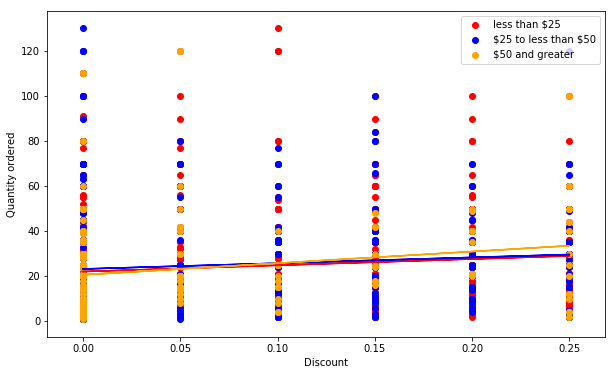

In [36]:
plt.figure(figsize=(10,6))
plt.scatter(x_less_25, y_less_25, label='less than $25', c='red')
plt.scatter(x_25_50, y_25_50, label='\$25 to less than \$50', c='blue')
plt.scatter(x_50_greater, y_50_greater, label='$50 and greater',c='orange')

plt.plot(x_less_25, pred_1, c='red')
plt.plot(x_25_50, pred_2, c='blue')
plt.plot(x_50_greater, pred_3, c='orange')
plt.xlabel('Discount')
plt.ylabel('Quantity ordered')
plt.legend()
plt.show();

This graph plots regression lines for the three bins of cost. It's difficult to see whether high cost items are lower or the same as the other categories when discount amount is low. So the graph below zooms in.

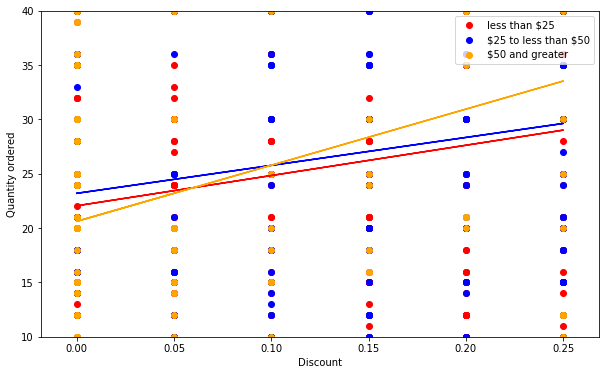

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(x_less_25, y_less_25, label='less than $25', c='red')
plt.scatter(x_25_50, y_25_50, label='\$25 to less than \$50', c='blue')
plt.scatter(x_50_greater, y_50_greater, label='$50 and greater',c='orange')

plt.plot(x_less_25, pred_1, c='red')
plt.plot(x_25_50, pred_2, c='blue')
plt.plot(x_50_greater, pred_3, c='orange')
plt.xlabel('Discount')
plt.ylabel('Quantity ordered')
plt.ylim(10, 40)
plt.legend()
plt.show();

We can see here that there is an interaction between discount & unit price. at 5\% discount the items that are greater than \\$50 have fewer quantities ordered than the other two categories, at 10\% the same as those that are \\$25 - 50, and then after 15\% is surpasses the other two categories. This makes sense as a larger discount on a more expensive items, means the total dollar savings will be greater. 

#### Build an interaction model to determine whether interaction is significant.

In [41]:
X_interact_categorical = X.drop(columns=['Quantity']).copy()
X_interact_categorical['UnitPrice_Discount'] = df['UnitPrice'] * df['Discount']

In [43]:
y = X['Quantity']

In [44]:
X_interact_categorical = sm.add_constant(X_interact_categorical)
model = sm.OLS(y,X_interact_categorical)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     7.296
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-08
Time:                        14:03:50   Log-Likelihood:                -9343.4
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2139   BIC:                         1.875e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 22.1304      0.640     34.565      0.000      20.875      23.386
UnitPrice             -0.0073      0.016     -0.453      0.650      -0.039       0.024
discount_00           -0.2249      0.833     -0.270      0.787      -1.859       1.409
discount_005           5.7175      1.299      4.402      0.000       3.170       8.265
discount_01            2.6574      1.301      2.043      0.041       0.107       5.208
discount_015           5.5532      1.360      4.083      0.000       2.886       8.220
discount_02            3.8837      1.383      2.809      0.005       1.173       6.595
discount_025           4.5435      1.547      2.937      0.003       1.509       7.578
UnitPrice_Discount     0.2511      0.179      1.401      0.161      -0.100       0.603
==============================================================================
Omnibus:                      786.913   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3094.777
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                       7.692   Cond. No.                     6.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.41e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The interaction is not significant. 

### Cross-Validation on Baseline & Interaction models

In [46]:
regression_baseline = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)


baseline = np.mean(cross_val_score(regression_baseline, X.drop(columns=['Quantity', 'UnitPrice']), y, scoring='r2', cv=crossvalidation))
baseline

0.01418948965085994

In [47]:
regression_interact = LinearRegression()

interact_model_score = np.mean(cross_val_score(regression_interact, X_interact_categorical, y, scoring='r2', cv=crossvalidation))
interact_model_score

0.013715108304171478

Consistent with the interaction of price & discount amount, cross-validation shows that includng the interaction does not yield in a better model.